## Imports

In [1]:
import os
import random
import re
from shutil import rmtree
from string import punctuation
from tempfile import mkdtemp

from google.colab import drive
from joblib import Memory
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import randomized_svd


######################################
# SET SEED
######################################

np.random.seed(42)
random.seed(42)


## Setup

In [22]:
nltk.download("all")

!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install scipy
!pip install umap-learn

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Found existing installation: scikit-learn 1.4.0
Uninstalling scikit-learn-1.4.0:
  Successfully uninstalled scikit-learn-1.4.0
  Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e7f75e2d690bd1f18c0ffe8fb17fd522fd2e37205dbd00c14f39f08d05c27d2d
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [3]:
######################################
# LOAD DATA
######################################

drive.mount("/content/drive")

# os.chdir("/content/drive/MyDrive/courses/masters/winter 24/ece 219/project 1")
os.chdir("/content/drive/MyDrive/ece 219/project 1")

dataset = pd.read_csv("dataset.csv")

print (dataset.shape)
print (dataset.columns)
print (dataset.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(3476, 8)
Index(['full_text', 'summary', 'keywords', 'publish_date', 'authors', 'url',
       'leaf_label', 'root_label'],
      dtype='object')
                                           full_text  \
0  'Personalize Your NBA App Experience for the '...   
1  'Mike Will attends the Pre-GRAMMY Gala and GRA...   
2  'The Golden State Warriors are struggling to f...   
3  'On Nov. 28, the NBA and Nike will collaborate...   
4  'The NBA announced additions and innovations t...   

                                             summary  \
0  'Personalize Your NBA App Experience for the '...   
1  'Mike WiLL Made-It has secured a partnership w...   
2  'The Golden State Warriors are struggling to f...   
3  'On Nov. 28, the NBA and Nike will collaborate...   
4  'The NBA announced additions and innovations t...   

                                            keywords

## Feature Extraction

In [4]:
########################
# INITIAL PROCESSING
########################

def count_alphanumeric_chars(full_text):
  """Count alphanumeric chars in a datapoint."""
  counts = [sum([ch.isalnum() for ch in datapoint]) for datapoint in full_text]
  return counts

full_text = dataset["full_text"].values

alphanumeric_char_count = count_alphanumeric_chars(full_text)
print (len(alphanumeric_char_count))

leaf_label = dataset["leaf_label"].values
root_label = dataset["root_label"].values

3476


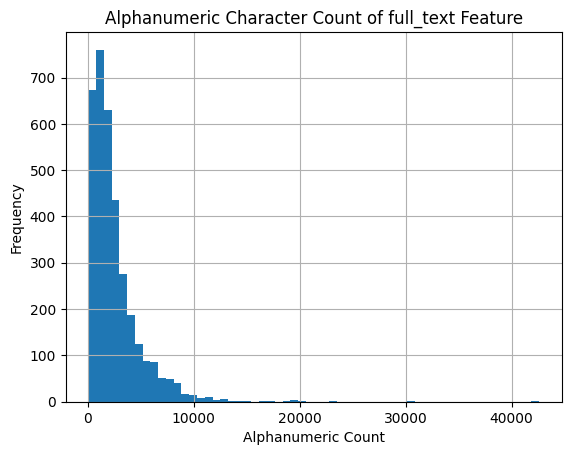

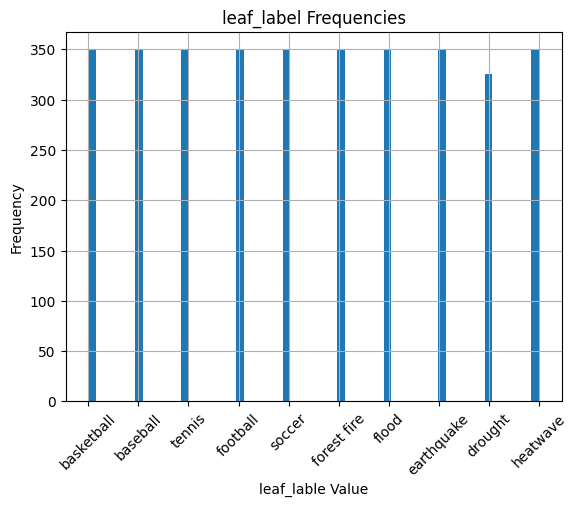

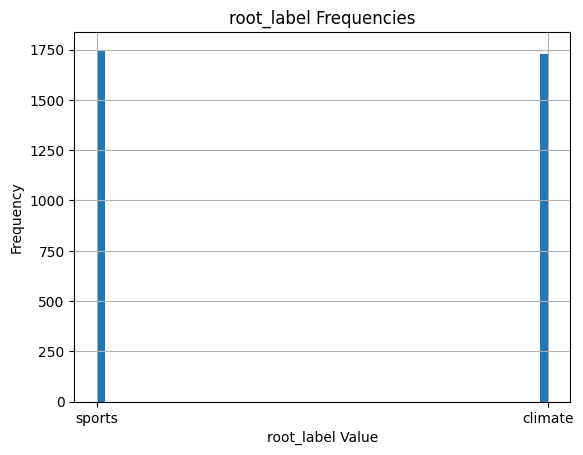

In [5]:
########################
# INITIAL VISUALIZATIONS
########################

plt.hist(alphanumeric_char_count, bins=int(np.sqrt(len(alphanumeric_char_count))))
plt.title("Alphanumeric Character Count of full_text Feature")
plt.xlabel("Alphanumeric Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.hist(leaf_label, bins=int(np.sqrt(len(leaf_label))))
plt.title("leaf_label Frequencies")
plt.xlabel("leaf_lable Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.hist(root_label, bins=int(np.sqrt(len(root_label))))
plt.title("root_label Frequencies")
plt.xlabel("root_label Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [6]:
########################
# GENERATE TRAIN TEST SPLITS
########################

train, test = train_test_split(dataset[["full_text", "root_label", "leaf_label"]], test_size=0.2)

print (train.shape)
print (test.shape)

(2780, 3)
(696, 3)


## TF-IDF

In [7]:
########################
# CLEAN OUT HTML ARTIFACTS
########################

def clean(text):
  """Clean text."""
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

full_text_clean_train = train["full_text"].map(clean)
full_text_clean_test = test["full_text"].map(clean)

print (full_text_clean_train.shape)
print (full_text_clean_test.shape)

(2780,)
(696,)


In [8]:
########################
# LEMMATIZE TEXT
########################

def penn2morphy(penntag):
  morphy_tag = {"NN": "n", "JJ": "a",
                "VB": "v", "RB": "r"}
  return morphy_tag.get(penntag[:2], "n")

def lemmatize(sentence):
  """Lemmatize a sentence given sentence. Filter out all words (lemma) which contain punctuation or numbers."""
  def is_number(lemma):
    """Return if lemma contains any characters or punctuations, which should

    filter out all numbers and decimals.
    """
    return any(char in lemma for char in punctuation) or any(char.isdigit() for char in lemma)

  lemmatized = []
  lemmas = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(word_tokenize(sentence))]
  for lemma in lemmas:
    if not is_number(lemma):
      lemmatized.append(lemma.lower())
  return " ".join(lemmatized)

lemmatizer = WordNetLemmatizer()
lemmatized_train = full_text_clean_train.map(lemmatize)
lemmatized_test = full_text_clean_test.map(lemmatize)

print (lemmatized_train.shape)
print (lemmatized_test.shape)

(2780,)
(696,)


In [9]:
########################
# COUNT VECTORIZATION
########################

count_vec = CountVectorizer(min_df=3, stop_words="english")

# Turn lemmatized text into count vector
count_vec_train = count_vec.fit_transform(lemmatized_train)
count_vec_test = count_vec.transform(lemmatized_test)

print (count_vec_train.shape)
print (count_vec_test.shape)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

print (counts_train.shape)
print (counts_test.shape)

(2780, 12781)
(696, 12781)
(2780, 12781)
(696, 12781)


In [10]:
# See how varying min_df changes TF-IDF matrix
min_dfs = range(1, 5)
for min_df in min_dfs:
    count_vec_tmp = CountVectorizer(min_df=min_df, stop_words="english")
    count_vec_tmp_train = count_vec_tmp.fit_transform(lemmatized_train)
    counts_train_tmp = tfidf_transformer.fit_transform(count_vec_tmp_train)
    print (counts_train_tmp.shape)

(2780, 31051)
(2780, 18251)
(2780, 12781)
(2780, 10538)


In [11]:
########################
# DIMENSIONALITY REDUCTION FUNCTIONS
########################

def LSI(n_components, train_data, test_data):
  """Perform Latent Semantic Indexing, and calculate MSEs."""
  print (f"Performing LSI for {n_components} component(s)")

  svd = TruncatedSVD(n_components=n_components, random_state=42)

  LSI_train = svd.fit_transform(train_data)
  print (f"LSI Train Data Shape: {LSI_train.shape}")

  U_tr, S_tr, V_tr = randomized_svd(train_data, n_components=n_components, random_state=42)
  print (f"LSI Train Error: {np.sum(np.array(train_data - (U_tr.dot(np.diag(S_tr)).dot(V_tr)))**2)}")

  LSI_test = svd.transform(test_data)
  print (f"LSI Test Data Shape: {LSI_test.shape}")

  U_te, S_te, V_te = randomized_svd(test_data, n_components=n_components, random_state=42)
  print (f"LSI Test Error: {np.sum(np.array(test_data - (U_te.dot(np.diag(S_te)).dot(V_te)))**2)}")
  print ("\n")

  return LSI_train, LSI_test, svd.explained_variance_ratio_


def perform_NMF(n_components, train_data, test_data):
  """Perform Non-negative Matrix Factorization, and calculate MSEs."""
  print (f"Performing NMF for {n_components} component(s)")

  # There might be a weird bug here where it says NMF() has an unexpected keyword argument "init"
  # I just had to rerun the first code block with the imports where I reinstalled sci-kit learn to update the version
  # This fixed it but it stopped working again later, so not sure if it will happen again
  nmf = NMF(n_components=n_components, init="random", random_state=42)

  NMF_train = nmf.fit_transform(train_data)
  print (f"NMF Train Data Shape: {NMF_train.shape}")

  print (f"NMF Train error: {np.sum(np.array(train_data - NMF_train.dot(nmf.components_))**2)}")

  NMF_test = nmf.transform(test_data)
  print (f"NMF Test Data Shape: {NMF_test.shape}")

  print (f"NMF Test error: {np.sum(np.array(test_data - NMF_test.dot(nmf.components_))**2)}")
  print ("\n")

  return NMF_train, NMF_test


In [12]:
########################
# PERFORM DIMENSIONALITY REDUCTION
########################

# Compute and plot explained variance ratio vs component number for LSI
n_components = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratios = []
for k in n_components:
  _, _, explained_variance_ratio = LSI(k, counts_train, counts_test)
  explained_variance_ratios.append(explained_variance_ratio)

Performing LSI for 1 component(s)
LSI Train Data Shape: (2780, 1)
LSI Train Error: 2677.15853840884
LSI Test Data Shape: (696, 1)
LSI Test Error: 669.1514264594656


Performing LSI for 10 component(s)
LSI Train Data Shape: (2780, 10)
LSI Train Error: 2373.767727003594
LSI Test Data Shape: (696, 10)
LSI Test Error: 591.3055828245604


Performing LSI for 50 component(s)
LSI Train Data Shape: (2780, 50)
LSI Train Error: 1949.0010053304213
LSI Test Data Shape: (696, 50)
LSI Test Error: 465.40075558429896


Performing LSI for 100 component(s)
LSI Train Data Shape: (2780, 100)
LSI Train Error: 1706.74410136712
LSI Test Data Shape: (696, 100)
LSI Test Error: 380.38188785747184


Performing LSI for 200 component(s)
LSI Train Data Shape: (2780, 200)
LSI Train Error: 1400.6612921911894
LSI Test Data Shape: (696, 200)
LSI Test Error: 259.56288382350925


Performing LSI for 500 component(s)
LSI Train Data Shape: (2780, 500)
LSI Train Error: 868.1768413022945
LSI Test Data Shape: (696, 500)
LSI Tes

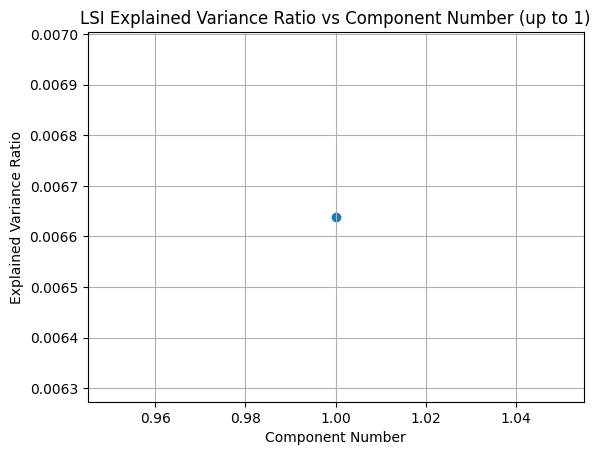

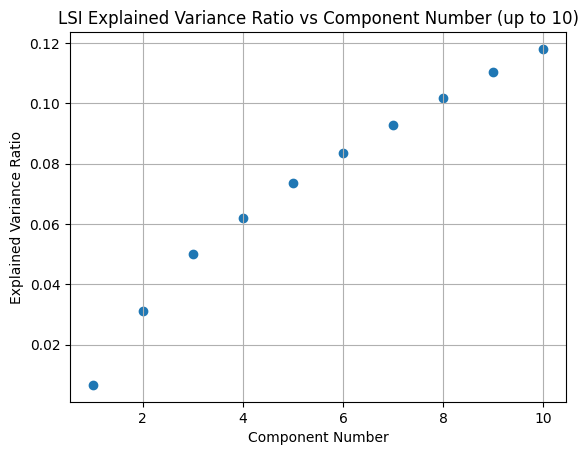

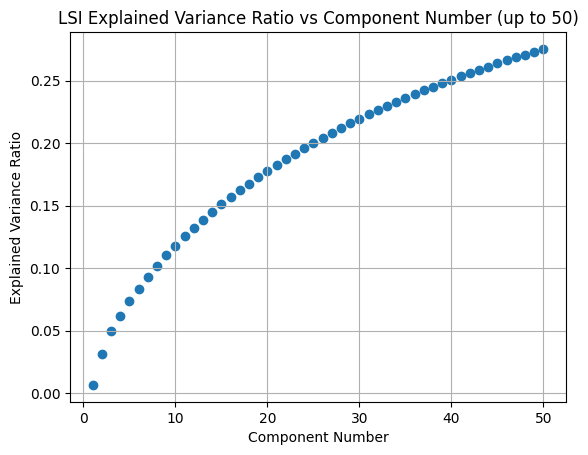

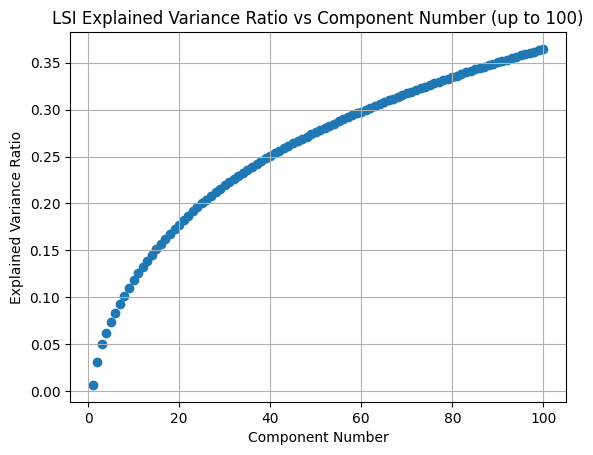

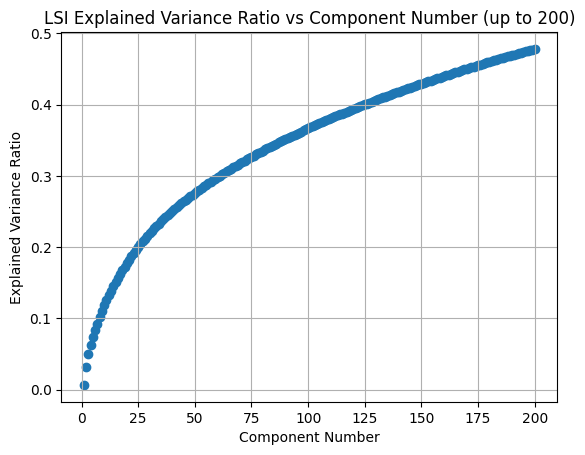

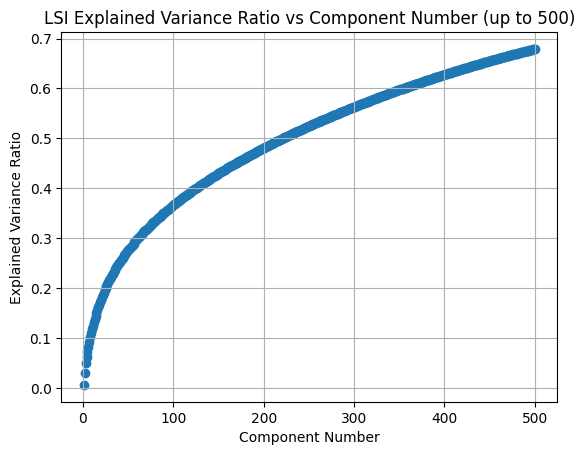

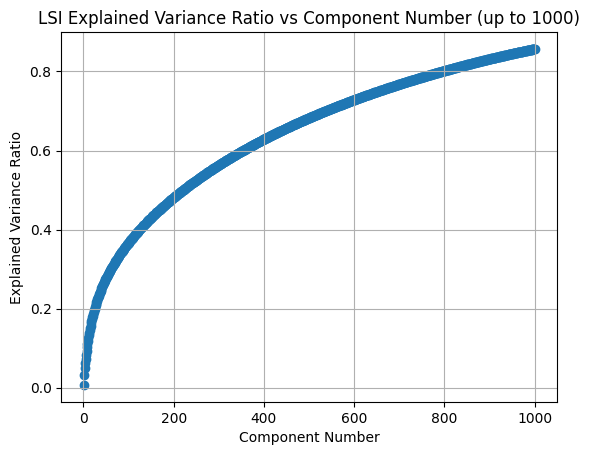

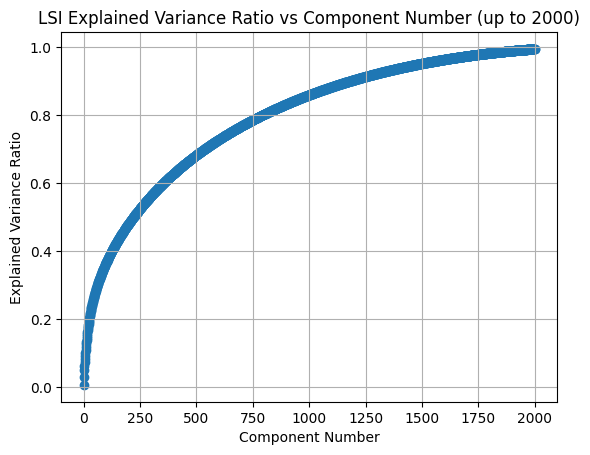

In [13]:
########################
# PERFORM DIMENSIONALITY REDUCTION CONT.
########################

# explained_variance_ratios_cumsum = [np.cumsum(evr) for evr in explained_variance_ratios]
# print (explained_variance_ratios[1])
# print (explained_variance_ratios_cumsum[1])
# TODO: not sure if we are supposed to have one plot, or multiple
# If only one plot, then I think we just use the last element of each evr in explained_variance_ratios, can update later
for k, evr in zip(n_components, explained_variance_ratios):
  evr_cumsum = np.cumsum(evr)
  plt.scatter([i+1 for i in range(k)], evr_cumsum)
  plt.title(f"LSI Explained Variance Ratio vs Component Number (up to {k})")
  plt.xlabel("Component Number")
  plt.ylabel("Explained Variance Ratio")
  plt.grid(True)
  plt.show()

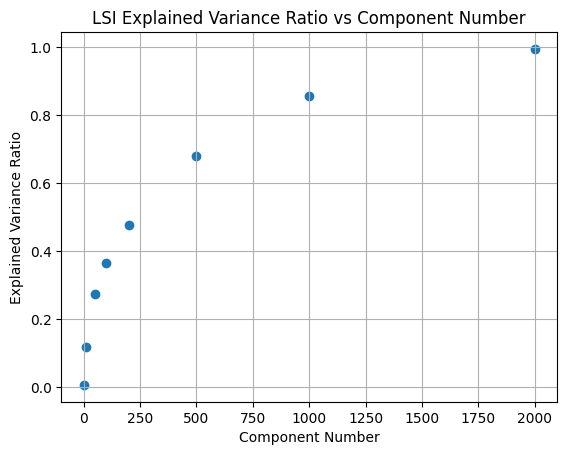

In [14]:
########################
# PERFORM DIMENSIONALITY REDUCTION CONT.
########################

# explained_variance_ratios_cumsum = [np.cumsum(evr) for evr in explained_variance_ratios]
# print (explained_variance_ratios[1])
# print (explained_variance_ratios_cumsum[1])
# TODO: not sure if we are supposed to have one plot, or multiple
# If only one plot, then I think we just use the last element of each evr in explained_variance_ratios, can update later
evr_cumsums = [np.cumsum(evr)[-1] for evr in explained_variance_ratios]
plt.scatter(n_components, evr_cumsums)
plt.title(f"LSI Explained Variance Ratio vs Component Number")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

In [15]:
# LSI and NMF using k = 50 components
LSI_train, LSI_test, _ = LSI(50, counts_train, counts_test)
NMF_train, NMF_test = perform_NMF(50, counts_train, counts_test)

Performing LSI for 50 component(s)
LSI Train Data Shape: (2780, 50)
LSI Train Error: 1949.0010053304213
LSI Test Data Shape: (696, 50)
LSI Test Error: 465.40075558429896


Performing NMF for 50 component(s)
NMF Train Data Shape: (2780, 50)
NMF Train error: 1979.1880820557803
NMF Test Data Shape: (696, 50)
NMF Test error: 520.863255498483




## SVM classification

In [ ]:
########################
# SVM CLASSIFICATION
########################

label_train = []
label_test = []
for label in train.root_label:
    if label == "sports":
        label_train.append(0)
    else:
        label_train.append(1)
for label in test.root_label:
    if label == "sports":
        label_test.append(0)
    else:
        label_test.append(1)

print (label_train)
print (label_test)

[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 

In [ ]:
########################
# SVM CLASSIFICATION
########################

clf_hard = svm.SVC(kernel='linear',C=1000,random_state=42)
clf_soft = svm.SVC(kernel='linear',C=0.0001,random_state=42)
clf_hardest = svm.SVC(kernel='linear',C=100000,random_state=42)

pred_hard = clf_hard.fit(LSI_train, label_train).predict(LSI_test)
pred_soft = clf_soft.fit(LSI_train, label_train).predict(LSI_test)
pred_hardest = clf_hardest.fit(LSI_train, label_train).predict(LSI_test)

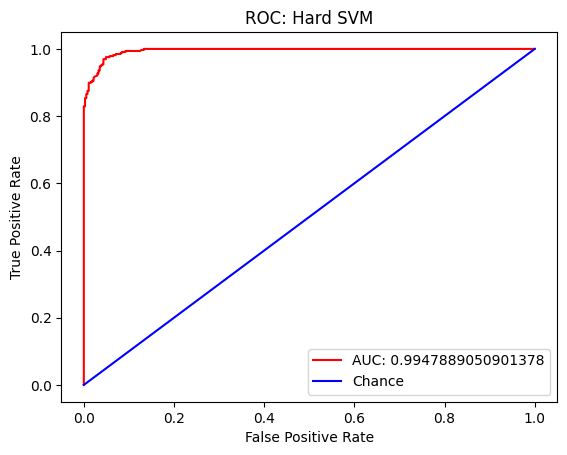

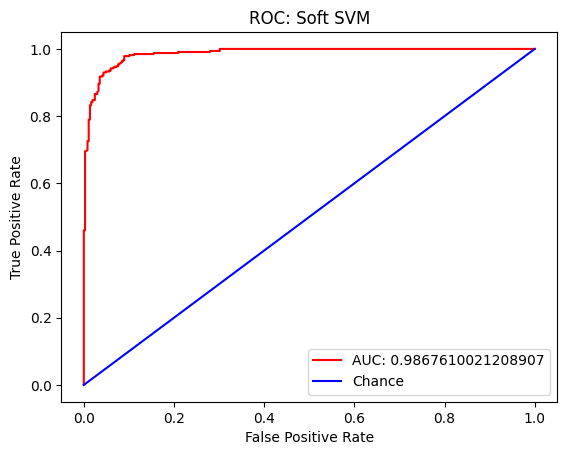

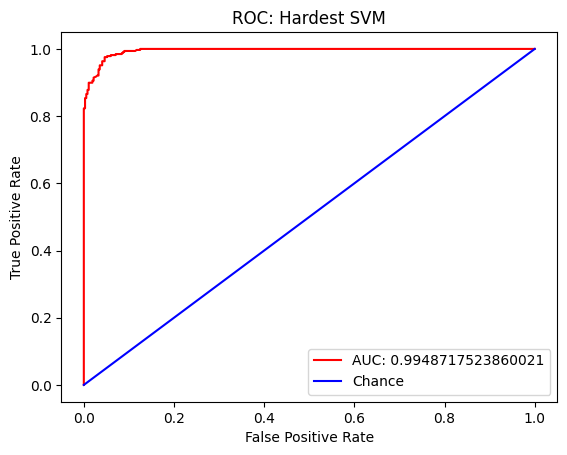

In [ ]:
fpr_hard, tpr_hard, _ = roc_curve(label_test, clf_hard.decision_function(LSI_test))
roc_auc_hard = auc(fpr_hard, tpr_hard)

plt.figure()
plt.plot(fpr_hard, tpr_hard, color='r', label=f"AUC: {roc_auc_hard}")
plt.plot([0, 1], [0, 1], color='b', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Hard SVM')
plt.legend(loc="lower right")
plt.show()

fpr_soft, tpr_soft, _ = roc_curve(label_test, clf_soft.decision_function(LSI_test))
roc_auc_soft = auc(fpr_soft, tpr_soft)

plt.figure()
plt.plot(fpr_soft, tpr_soft, color='r', label=f"AUC: {roc_auc_soft}")
plt.plot([0, 1], [0, 1], color='b', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Soft SVM')
plt.legend(loc="lower right")
plt.show()

fpr_hardest, tpr_hardest, _ = roc_curve(label_test, clf_hardest.decision_function(LSI_test))
roc_auc_hardest = auc(fpr_hardest, tpr_hardest)

plt.figure()
plt.plot(fpr_hardest, tpr_hardest, color='r', label=f"AUC: {roc_auc_hardest}")
plt.plot([0, 1], [0, 1], color='b', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Hardest SVM')
plt.legend(loc="lower right")
plt.show()


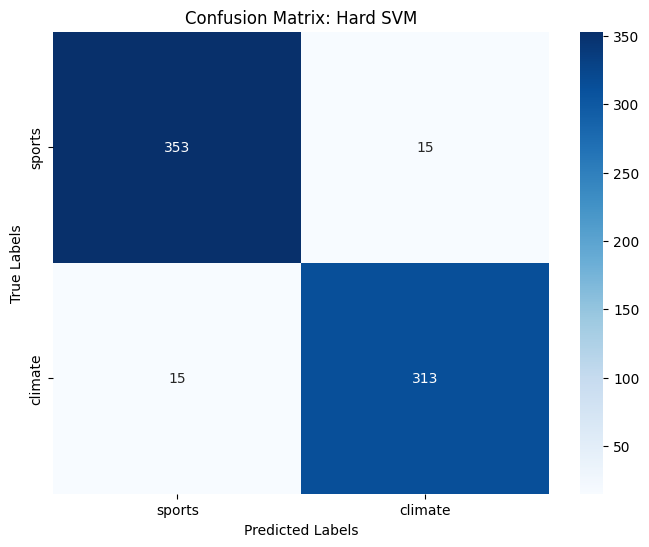

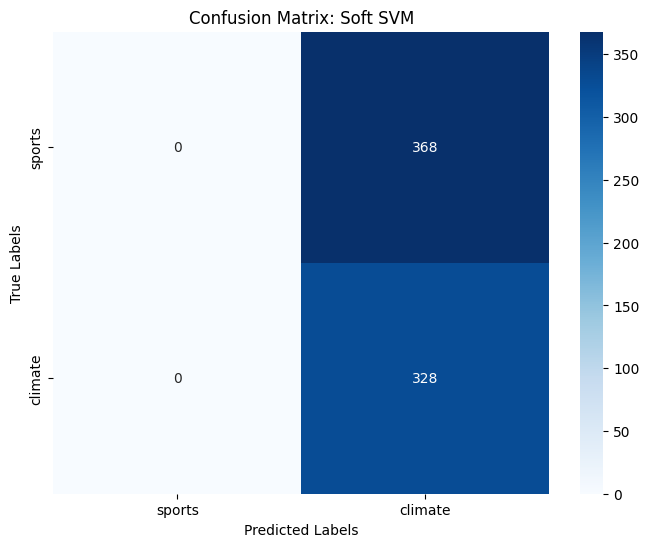

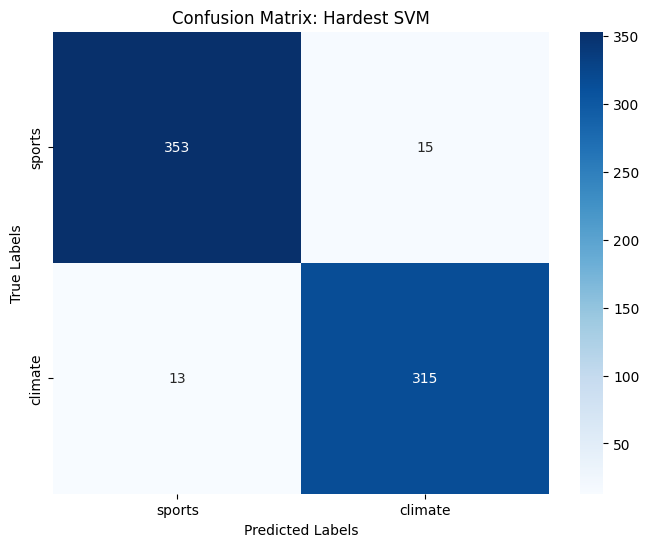

In [ ]:
pred_hard = clf_hard.predict(LSI_test)
unique_labels = sorted(set(label_test))
cm_hard = confusion_matrix(label_test, pred_hard, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues', xticklabels=['sports', 'climate'], yticklabels=['sports', 'climate'])
plt.title('Confusion Matrix: Hard SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

pred_soft = clf_soft.predict(LSI_test)
cm_soft = confusion_matrix(label_test, pred_soft, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues', xticklabels=['sports', 'climate'], yticklabels=['sports', 'climate'])
plt.title('Confusion Matrix: Soft SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

pred_hardest = clf_hardest.predict(LSI_test)
cm_hardest = confusion_matrix(label_test, pred_hardest, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hardest, annot=True, fmt='d', cmap='Blues', xticklabels=['sports', 'climate'], yticklabels=['sports', 'climate'])
plt.title('Confusion Matrix: Hardest SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print("Accuracy hard SVM:", accuracy_score(label_test, pred_hard))
print("Precision hard SVM:", precision_score(label_test, pred_hard))
print("F1 Score hard SVM:", f1_score(label_test, pred_hard))
print("Recall hard SVM:", recall_score(label_test, pred_hard))


print("Accuracy soft SVM:", accuracy_score(label_test, pred_soft))
print("Precision soft SVM:", precision_score(label_test, pred_soft))
print("F1 Score soft SVM:", f1_score(label_test, pred_soft))
print("Recall soft SVM:", recall_score(label_test, pred_soft))


print("Accuracy hardest SVM:", accuracy_score(label_test, pred_hardest))
print("Precision hardest SVM:", precision_score(label_test, pred_hardest))
print("F1 Score hardest SVM:", f1_score(label_test, pred_hardest))
print("Recall hardest SVM:", recall_score(label_test, pred_hardest))

Accuracy hard SVM: 0.9568965517241379
Precision hard SVM: 0.9542682926829268
F1 Score hard SVM: 0.9542682926829268
Recall hard SVM: 0.9542682926829268
Accuracy soft SVM: 0.47126436781609193
Precision soft SVM: 0.47126436781609193
F1 Score soft SVM: 0.640625
Recall soft SVM: 1.0
Accuracy hardest SVM: 0.9597701149425287
Precision hardest SVM: 0.9545454545454546
F1 Score hardest SVM: 0.9574468085106382
Recall hardest SVM: 0.9603658536585366


In [ ]:
clf_cv = svm.SVC(random_state=42)
c_values = {'C': [0.001,0.01,0.1,1,10,100,1000],
              'kernel': ['linear']}
grid = GridSearchCV(clf_cv, c_values, cv=5, scoring='accuracy')
grid.fit(LSI_train, label_train)

pred_cv = grid.best_estimator_.predict(LSI_test)
print('Gamma Best:', grid.best_params_['C'])
for l, n in zip(c_values['C'], grid.cv_results_['mean_test_score']):
    print(f'Gamma: {l}')
    print(f'Average Cross Validation Accuracy: {n}')

Gamma Best: 10
Gamma: 0.001
Average Cross Validation Accuracy: 0.5028776978417266
Gamma: 0.01
Average Cross Validation Accuracy: 0.779136690647482
Gamma: 0.1
Average Cross Validation Accuracy: 0.939568345323741
Gamma: 1
Average Cross Validation Accuracy: 0.95
Gamma: 10
Average Cross Validation Accuracy: 0.9546762589928057
Gamma: 100
Average Cross Validation Accuracy: 0.9535971223021582
Gamma: 1000
Average Cross Validation Accuracy: 0.9532374100719425


In [ ]:
print('Gamma Best',grid.best_params_['C'])
SVM_best_gamma = grid.best_params_['C']
for l, n in zip(c_values['C'],grid.cv_results_['mean_test_score']):
    print(f'Gamma: {l}')
    print(f'Average Cross Validation Accuracy: {n}')

Gamma Best 10
Gamma: 0.001
Average Cross Validation Accuracy: 0.5028776978417266
Gamma: 0.01
Average Cross Validation Accuracy: 0.779136690647482
Gamma: 0.1
Average Cross Validation Accuracy: 0.939568345323741
Gamma: 1
Average Cross Validation Accuracy: 0.95
Gamma: 10
Average Cross Validation Accuracy: 0.9546762589928057
Gamma: 100
Average Cross Validation Accuracy: 0.9535971223021582
Gamma: 1000
Average Cross Validation Accuracy: 0.9532374100719425


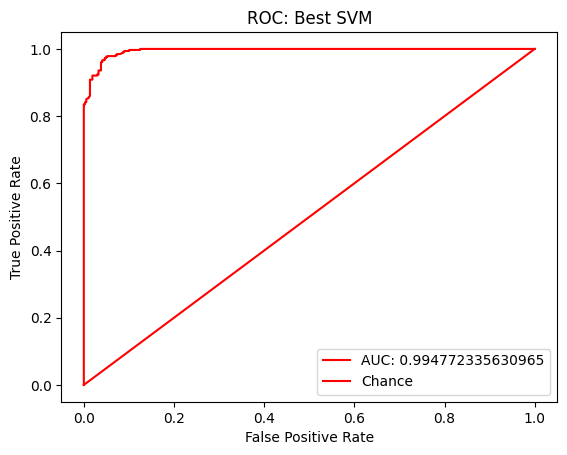

In [ ]:
best_estimator = grid.best_estimator_

# Get predicted probabilities
y = best_estimator.decision_function(LSI_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(label_test, y)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='r',label=f"AUC: {roc_auc}")
plt.plot([0, 1], [0, 1], color='r', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Best SVM')
plt.legend(loc="lower right")
plt.show()

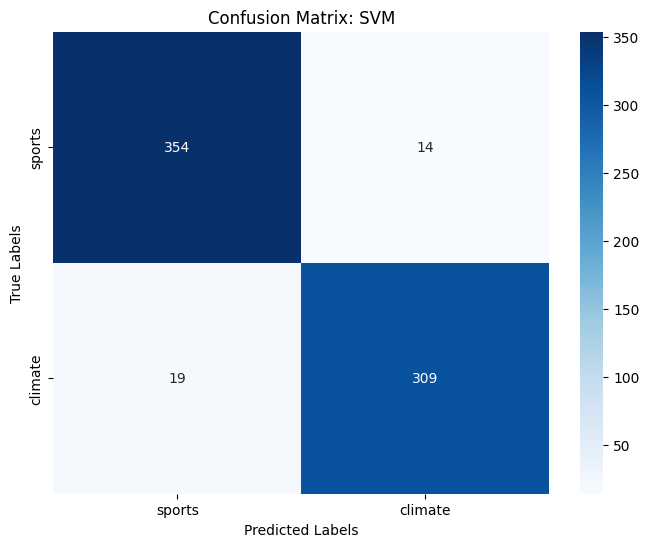

In [ ]:
y_pred = best_estimator.predict(LSI_test)

cm = confusion_matrix(label_test, y_pred, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sports', 'climate'], yticklabels=['sports', 'climate'])
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print("Accuracy SVM:", accuracy_score(label_test,pred_cv))
print("Precision SVM:", precision_score(label_test,pred_cv))
print("F1-Score SVM:", f1_score(label_test,pred_cv))
print("Recall SVM:", recall_score(label_test,pred_cv))


Accuracy SVM: 0.9525862068965517
Precision SVM: 0.9566563467492261
F1-Score SVM: 0.9493087557603687
Recall SVM: 0.9420731707317073


## Logistic Regression

In [ ]:
clf_lf_no_reg = LogisticRegression(C = 1000000, random_state = 42, max_iter = 100000)
pred_lf_no_reg = clf_lf_no_reg.fit(LSI_train, label_train).predict(LSI_test)

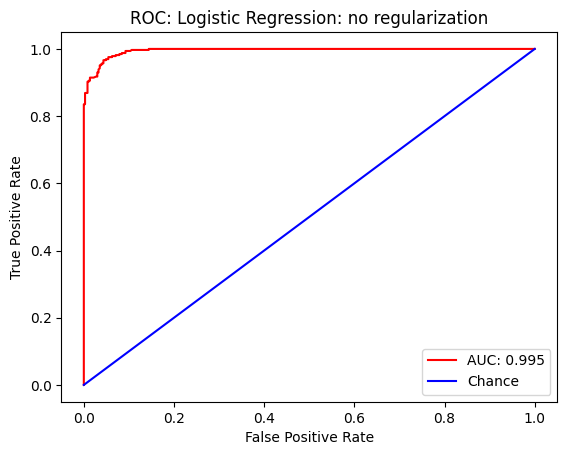

In [ ]:
scores = clf_lf_no_reg.decision_function(LSI_test)
fpr, tpr, _ = roc_curve(label_test, scores)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color ='r', label = "AUC: {:.3f}".format(roc_auc))
ax.plot([0, 1], [0, 1], color='b', label = 'Chance')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC: Logistic Regression: no regularization')
ax.legend(loc="lower right")

plt.show()

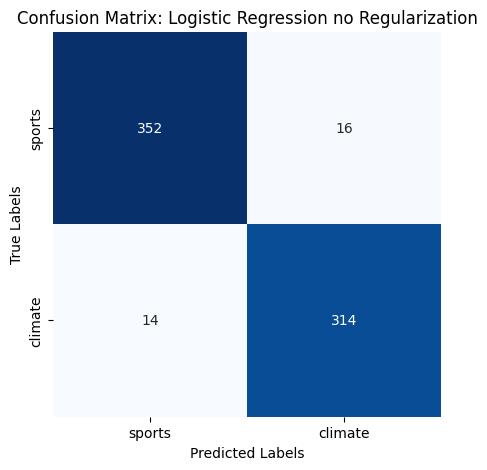

In [ ]:
y_pred = clf_lf_no_reg.predict(LSI_test)

cm = confusion_matrix(label_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot = True, fmt= 'd', cmap='Blues', cbar=False,
            xticklabels=['sports', 'climate'],
            yticklabels=['sports', 'climate'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Logistic Regression no Regularization')

plt.show()

In [ ]:
print("Accuracy (Logistic Regression no regularization):", accuracy_score(label_test,pred_lf_no_reg))
print("Recall (Logistic Regression no regularization):", recall_score(label_test,pred_lf_no_reg))
print("Precision (Logistic Regression no regularization):", precision_score(label_test,pred_lf_no_reg))
print("F1-Score (Logistic Regression no regularization):", f1_score(label_test,pred_lf_no_reg))

Accuracy (Logistic Regression no regularization): 0.9568965517241379
Recall (Logistic Regression no regularization): 0.9573170731707317
Precision (Logistic Regression no regularization): 0.9515151515151515
F1-Score (Logistic Regression no regularization): 0.9544072948328268


In [ ]:
clf_lr_l1 = LogisticRegression(penalty = 'l1', random_state = 42, solver ='liblinear', max_iter=100000)
c_values = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_l1 = GridSearchCV(clf_lr_l1, c_values, cv = 5, scoring = 'accuracy')
grid_l1.fit(LSI_train, label_train)
pred_cv_lr_l1 = grid_l1.best_estimator_.predict(LSI_test)

clf_lr_l2 = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=42)
grid_l2 = GridSearchCV(clf_lr_l2, c_values, cv=5, scoring ='accuracy')
grid_l2.fit(LSI_train, label_train)
pred_cv_lr_l2 = grid_l2.best_estimator_.predict(LSI_test)

In [ ]:
l1_best = grid_l1.best_params_['C']
for i, j in zip(c_values['C'],grid_l1.cv_results_['mean_test_score']):
    print(f'L1 Parameter: {i}')
    print(f'Average Cross Validation Accuracy: {j}')

l2_best = grid_l2.best_params_['C']
for i, j in zip(c_values['C'],grid_l2.cv_results_['mean_test_score']):
    print(f'L2 Parameter: {i}')
    print(f'Average Cross Validation Accuracy: {j}')

print('Best L1 Reg Parameter:',grid_l1.best_params_['C'])
print('Best L2 Reg Parameter:',grid_l2.best_params_['C'])


L1 Parameter: 1e-05
Average Cross Validation Accuracy: 0.4971223021582734
L1 Parameter: 0.0001
Average Cross Validation Accuracy: 0.4971223021582734
L1 Parameter: 0.001
Average Cross Validation Accuracy: 0.4971223021582734
L1 Parameter: 0.01
Average Cross Validation Accuracy: 0.4971223021582734
L1 Parameter: 0.1
Average Cross Validation Accuracy: 0.926978417266187
L1 Parameter: 1
Average Cross Validation Accuracy: 0.9485611510791367
L1 Parameter: 10
Average Cross Validation Accuracy: 0.9535971223021583
L1 Parameter: 100
Average Cross Validation Accuracy: 0.953956834532374
L1 Parameter: 1000
Average Cross Validation Accuracy: 0.9535971223021582
L1 Parameter: 10000
Average Cross Validation Accuracy: 0.9532374100719423
L1 Parameter: 100000
Average Cross Validation Accuracy: 0.9532374100719423
L2 Parameter: 1e-05
Average Cross Validation Accuracy: 0.8636690647482013
L2 Parameter: 0.0001
Average Cross Validation Accuracy: 0.8744604316546762
L2 Parameter: 0.001
Average Cross Validation Accur

In [ ]:
print("L1 Accuracy:", accuracy_score(label_test,pred_cv_lr_l1 ))
print("L1 Recall:", recall_score(label_test,pred_cv_lr_l1 ))
print("L1 Precision:", precision_score(label_test,pred_cv_lr_l1 ))
print("L1 F1-Score:", f1_score(label_test,pred_cv_lr_l1 ))

print("L2 Accuracy:", accuracy_score(label_test,pred_cv_lr_l2 ))
print("L2 Recall:", recall_score(label_test,pred_cv_lr_l2 ))
print("L2 Precision:", precision_score(label_test,pred_cv_lr_l2 ))
print("L2 F1-Score:", f1_score(label_test,pred_cv_lr_l2))

L1 Accuracy: 0.9583333333333334
L1 Recall: 0.9573170731707317
L1 Precision: 0.9544072948328267
L1 F1-Score: 0.9558599695585996
L2 Accuracy: 0.9497126436781609
L2 Recall: 0.9420731707317073
L2 Precision: 0.9507692307692308
L2 F1-Score: 0.9464012251148545


In [ ]:
C_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
l1_accuracy_coeff = []
l1_mean_coeff = []
l2_accuracy_coeff = []
l2_mean_coeff = []

for j in C_list:
    clf_lr_l1_coeff = LogisticRegression(C=j,penalty='l1',random_state=42,solver='liblinear',max_iter=100000)
    pred_lr_l1_coeff = clf_lr_l1_coeff.fit(LSI_train,label_train).predict(LSI_test)

    l1_accuracy_coeff.append(accuracy_score(label_test,pred_lr_l1_coeff))
    l1_mean_coeff.append(np.mean(clf_lr_l1_coeff.coef_))

    clf_lr_l2_coeff = LogisticRegression(C=j,penalty='l2',random_state=42,solver='liblinear')
    pred_lr_l2_coeff = clf_lr_l2_coeff.fit(LSI_train,label_train).predict(LSI_test)

    l2_accuracy_coeff.append(accuracy_score(label_test,pred_lr_l2_coeff))
    l2_mean_coeff.append(np.mean(clf_lr_l2_coeff.coef_))

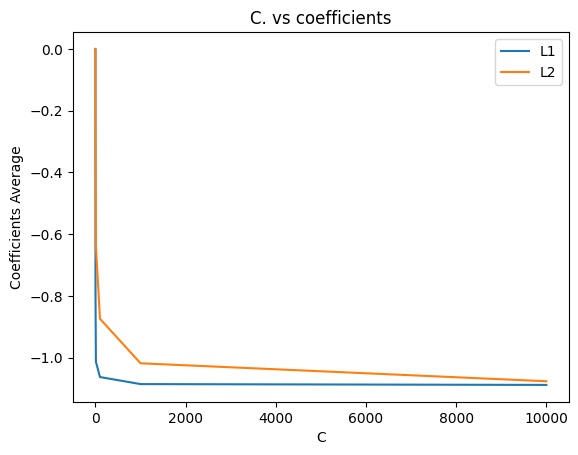

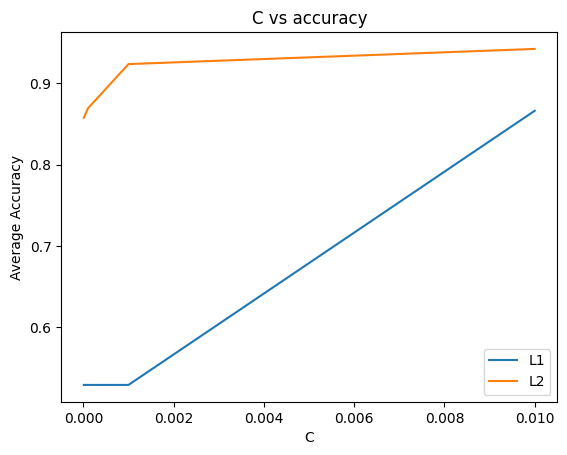

In [ ]:
fig, ax = plt.subplots()
plt.title('C. vs coefficients')
plt.plot(C_list[0:10],l1_mean_coeff[0:10],label='L1')
plt.plot(C_list[0:10],l2_mean_coeff[0:10],label='L2')
plt.xlabel('C')
plt.ylabel('Coefficients Average')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title('C vs accuracy')
plt.plot(C_list[0:4],l1_accuracy_coeff[0:4],label='L1')
plt.plot(C_list[0:4],l2_accuracy_coeff[0:4],label='L2')
plt.xlabel('C')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

## Naive Bayes classification

In [ ]:
clf_NB = GaussianNB()
pred_NB = clf_NB.fit(LSI_train, label_train).predict(LSI_test)

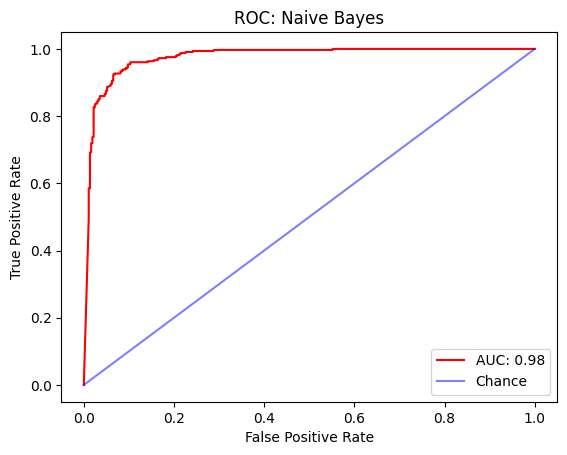

In [ ]:
y = clf_NB.predict_proba(LSI_test)[:, 1]

fpr, tpr, _ = roc_curve(label_test, y)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='r', label="AUC: {:.2f}".format(roc_auc))
ax.plot([0, 1], [0, 1], color='b', label='Chance', alpha=.5)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC: Naive Bayes')

ax.legend(loc="lower right")

plt.show()


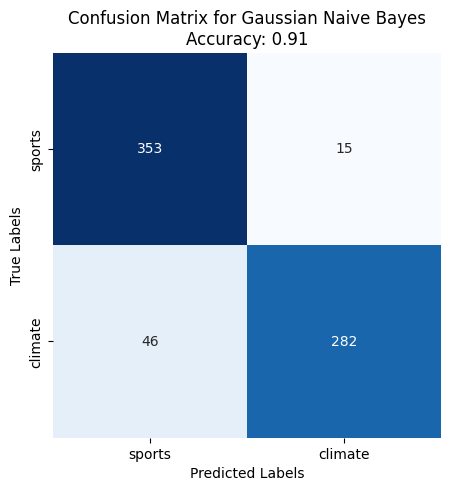

In [ ]:
# Get predictions
y_pred = clf_NB.predict(LSI_test)

# Compute confusion matrix
cm = confusion_matrix(label_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['sports', 'climate'],
            yticklabels=['sports', 'climate'])

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gaussian Naive Bayes\nAccuracy: {:.2f}'.format(accuracy_score(label_test, y_pred)))

# Save and show the plot
plt.show()


In [ ]:
print("Accuracy (Gaussian Naive Bayes):", accuracy_score(label_test,pred_NB))
print("Recall (Gaussian Naive Bayes):", recall_score(label_test,pred_NB))
print("Precision (Gaussian Naive Bayes):", precision_score(label_test,pred_NB))
print("F1-Score (Gaussian Naive Bayes):", f1_score(label_test,pred_NB))

Accuracy (Gaussian Naive Bayes): 0.9123563218390804
Recall (Gaussian Naive Bayes): 0.8597560975609756
Precision (Gaussian Naive Bayes): 0.9494949494949495
F1-Score (Gaussian Naive Bayes): 0.9024


## Grid Search Preparation

In [ ]:
def lemmatize(sentence):
  """Lemmatize a sentence given lemmatizer and sentence. Filter out all words (lemma) which contain punctuation or numbers."""
  def is_number(lemma):
    """Return if lemma contains any characters or punctuations, which should

    filter out all numbers and decimals.
    """
    return any(char in lemma for char in punctuation) or any(char.isdigit() for char in lemma)

  lemmatized = []
  lemmas = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(word_tokenize(sentence))]
  for lemma in lemmas:
    if not is_number(lemma):
      lemmatized.append(lemma.lower())
  return " ".join(lemmatized)

def stemmize(sentence):
  """Stemmize a sentence given and sentence. Filter out all words (stems) which contain punctuation or numbers."""
  def is_number(stem):
    """Return if stem contains any characters or punctuations, which should

    filter out all numbers and decimals.
    """
    return any(char in stem for char in punctuation) or any(char.isdigit() for char in stem)

  stemmized = []
  stems = [stemmer.stem(word.lower()) for word in word_tokenize(sentence)]
  for stem in stems:
    if not is_number(stem):
      stemmized.append(stem.lower())
  return " ".join(stemmized)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

## Create Pipeline

In [ ]:
# Cache results
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

pipeline = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("tfidf", TfidfTransformer()),
    ("dimensionality_reduction", None),
    ("classify", None),
  ],
  memory=memory,
)

# N_COMPONENTS_OPTIONS = [5, 30, 80]

c_values = [
    {
        "vect__min_df": (3, 5), # 2 choices
        "vect__analyzer": (lemmatize, stemmize), # 2 choices
        "dimensionality_reduction": [
            TruncatedSVD(n_components=5, random_state=42),
            TruncatedSVD(n_components=30, random_state=42),
            TruncatedSVD(n_components=80, random_state=42),
            NMF(n_components=5, init="random", random_state=42),
            NMF(n_components=30, init="random", random_state=42),
            NMF(n_components=80, init="random", random_state=42),
        ], # 6 choices
        # "dimensionality_reduction__n_components": N_COMPONENTS_OPTIONS, # 3 choices
        "classify": [
            svm.SVC(C=SVM_best_gamma, random_state=42),
            LogisticRegression(penalty="l2", C=l2_best, random_state=42),
            LogisticRegression(penalty="l1", C=l1_best, random_state=42),
            GaussianNB()
        ], # 4 choices
    }, # 96 total choices
]

## Grid Search

In [ ]:
grid = GridSearchCV(pipeline, cv=5, n_jobs=1, c_values=c_values, scoring="accuracy")
grid.fit(full_text_clean_train, label_train)

rmtree(cachedir)

In [ ]:
print (grid.best_params_)
print (grid.best_estimator_)
print (grid.cv_results_)

In [ ]:
ranked_test_scores = grid.cv_results_["rank_test_score"]
idx_to_score = {i: score for i, score in enumerate(ranked_test_scores)}
sorted_idxs = sorted(idx_to_score, key=lambda i: idx_to_score[i]) # sort indexes from least to greatest based on corresponding score

sorted_params = [grid.cv_results_["params"][i] for i in sorted_idxs]
top_5_params = sorted_params[:5]

for param in top_5_params:
  print (param)

for i in range(5):
  print (grid.cv_results_["mean_test_score"][sorted_idxs[i]])

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## Rerun Pipeline using Grid Search Results

### 1st Parameter Setting

In [ ]:
count_vec = CountVectorizer(min_df=3, stop_words="english")

# Turn lemmatized text into count vector
count_vec_train = count_vec.fit_transform(lemmatized_train)
count_vec_test = count_vec.transform(lemmatized_test)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

NMF_train, NMF_test = perform_NMF(30, counts_train, counts_test)

clf = svm.SVC(C=10, random_state=42)
label_test_pred = clf.fit(NMF_train, label_train).predict(NMF_test)
print (f"Test accuracy of parameter setting 1: {accuracy_score(label_test, label_test_pred)}")

Performing NMF for 30 component(s)
NMF Train Data Shape: (2780, 30)
NMF Train error: 2121.1663788939827
NMF Test Data Shape: (696, 30)
NMF Test error: 548.9462025135193


Test accuracy of parameter setting 1: 0.9497126436781609


### Second Parameter Setting



In [ ]:
count_vec = CountVectorizer(min_df=5, stop_words="english")

# Turn lemmatized text into count vector
count_vec_train = count_vec.fit_transform(lemmatized_train)
count_vec_test = count_vec.transform(lemmatized_test)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

NMF_train, NMF_test = perform_NMF(30, counts_train, counts_test)

clf = svm.SVC(C=SVM_best_gamma, random_state=42)
label_test_pred = clf.fit(NMF_train, label_train).predict(NMF_test)
print (f"Test accuracy of parameter settings {2}: {accuracy_score(label_test, label_test_pred)}")

Performing NMF for 30 component(s)
NMF Train Data Shape: (2780, 30)
NMF Train error: 2104.4631526265953
NMF Test Data Shape: (696, 30)
NMF Test error: 544.5259301784039


Test accuracy of parameter settings 2: 0.9583333333333334


### Third Parameter Setting


In [ ]:
stemmer = PorterStemmer()

stemmized_train = full_text_clean_train.map(stemmize)
stemmized_test = full_text_clean_test.map(stemmize)

count_vec = CountVectorizer(min_df=3, stop_words="english")

# Turn stemmized text into count vector
count_vec_train = count_vec.fit_transform(stemmized_train)
count_vec_test = count_vec.transform(stemmized_test)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

NMF_train, NMF_test = perform_NMF(30, counts_train, counts_test)

clf = svm.SVC(C=10, random_state=42)
label_test_pred = clf.fit(NMF_train, label_train).predict(NMF_test)
print (f"Test accuracy of parameter settings {3}: {accuracy_score(label_test, label_test_pred)}")

Performing NMF for 30 component(s)
NMF Train Data Shape: (2780, 30)
NMF Train error: 2100.5378740641254
NMF Test Data Shape: (696, 30)
NMF Test error: 542.1550540183221


Test accuracy of parameter settings 3: 0.9554597701149425


### Fourth Parameter Setting

In [ ]:
count_vec = CountVectorizer(min_df=5, stop_words="english")

# Turn stemmized text into count vector
count_vec_train = count_vec.fit_transform(stemmized_train)
count_vec_test = count_vec.transform(stemmized_test)

print (count_vec_train.shape)
print (count_vec_test.shape)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

NMF_train, NMF_test = perform_NMF(30, counts_train, counts_test)

clf = svm.SVC(C=10, random_state=42)
label_test_pred = clf.fit(NMF_train, label_train).predict(NMF_test)
print (f"Test accuracy of parameter settings {4}: {accuracy_score(label_test, label_test_pred)}")

(2780, 7973)
(696, 7973)
Performing NMF for 30 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  with config_context(assume_finite=True):


NMF Train Data Shape: (2780, 30)
NMF Train error: 2076.5428175145903
NMF Test Data Shape: (696, 30)
NMF Test error: 537.0383258223449


Test accuracy of parameter settings 4: 0.9583333333333334


### Fifth Parameter Setting

In [ ]:
count_vec = CountVectorizer(min_df=3, stop_words="english")

# Turn lemmatized text into count vector
count_vec_train = count_vec.fit_transform(lemmatized_train)
count_vec_test = count_vec.transform(lemmatized_test)

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

counts_train = tfidf_transformer.fit_transform(count_vec_train)
counts_test = tfidf_transformer.transform(count_vec_test)

NMF_train, NMF_test = perform_NMF(30, counts_train, counts_test)

lr = LogisticRegression(penalty="l2", C=10, random_state=42)
label_test_pred = lr.fit(NMF_train, label_train).predict(NMF_test)
print (f"Test accuracy of parameter settings {5}: {accuracy_score(label_test, label_test_pred)}")

Performing NMF for 30 component(s)
NMF Train Data Shape: (2780, 30)
NMF Train error: 2121.1663788939827
NMF Test Data Shape: (696, 30)
NMF Test error: 548.9462025135193


Test accuracy of parameter settings 5: 0.9339080459770115


## Multiclass classification

### Initialization

In [ ]:
## Labels
map_class_to_row = {
    "basketball": 0, "baseball": 1, "tennis": 2,
    "football": 3, "soccer": 4, "forest fire": 5,
    "flood": 6, "earthquake": 7, "drought": 8, "heatwave": 9
}
map_row_to_class = {
    0:"basketball", 1:"baseball", 2:"tennis", 3:"football",
    4:"soccer", 5:"forest fire", 6:"flood", 7:"earthquake",
    8:"drought", 9:"heatwave"
}
ordered_labels = sorted(map_row_to_class.values(), key=lambda x: map_class_to_row[x])

## Helpers
def class_name_to_int(y):
    return np.fromiter(map(lambda x: map_class_to_row[x], y), dtype=np.int32)
def class_int_to_name(y):
    return list(map(lambda x: map_row_to_class[x], y))

def show_scores(true_labels, predictions, average_type):
    print("Accuracy:", accuracy_score(true_labels, predictions))
    print("Recall:", recall_score(true_labels, predictions, average=average_type))
    print("Precision:", precision_score(true_labels, predictions, average=average_type))
    print("F1-Score:", f1_score(true_labels, predictions, average=average_type))

## Data
label_train = train.leaf_label
label_test = test.leaf_label

### Naive Bayes

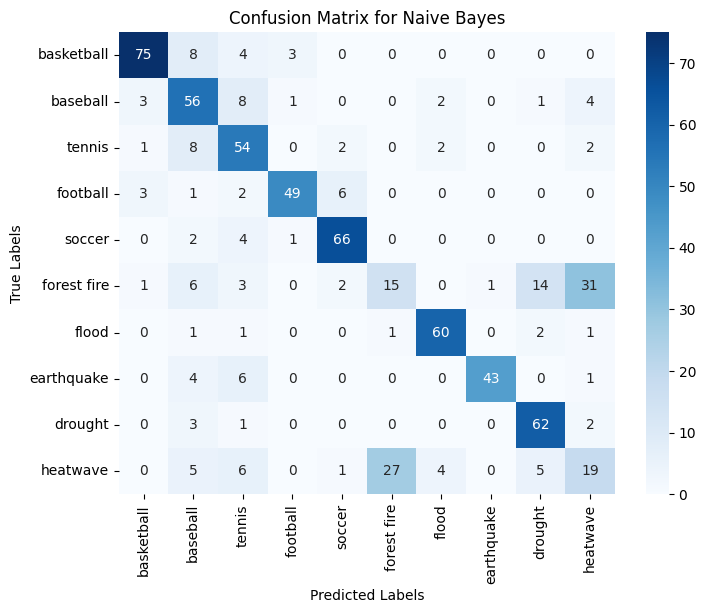

---Scores for Naive Bayes---
Accuracy: 0.7169540229885057
Recall: 0.7176210426094451
Precision: 0.713387575877979
F1-Score: 0.7092188303685902


In [ ]:
## Training and prediction
from sklearn.naive_bayes import GaussianNB

## Classifier
clf = GaussianNB()
predictions = clf.fit(LSI_train, label_train).predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test, predictions, labels=ordered_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Other scores
print("---Scores for Naive Bayes---")
show_scores(label_test, predictions, 'macro')

### One-vs-one SVM

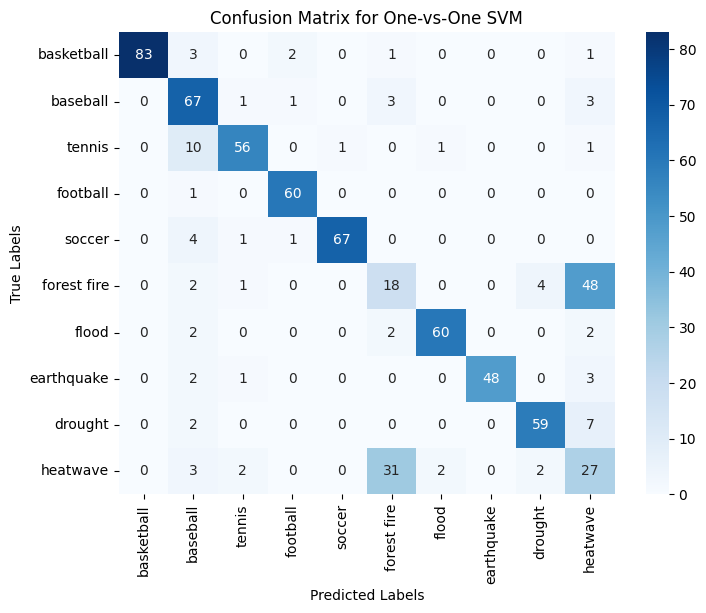

---Scores for One-vs-One SVM---
Accuracy: 0.7830459770114943
Recall: 0.7843751808905183
Precision: 0.8004760838980891
F1-Score: 0.7887979460588619


In [ ]:
from sklearn.multiclass import OneVsOneClassifier

## Classifier
# Using gamma = 10
clf = OneVsOneClassifier(svm.SVC(kernel='linear', C=10, random_state=42)).fit(LSI_train, label_train)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test, predictions, labels=ordered_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.title('Confusion Matrix for One-vs-One SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Other scores
print("---Scores for One-vs-One SVM---")
show_scores(label_test, predictions, 'macro')

### One-vs-rest SVM

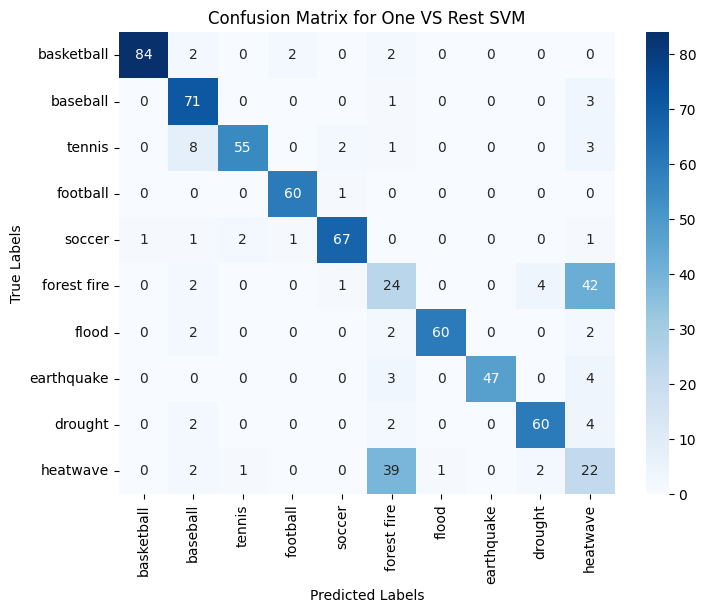

---Scores for One-vs-Rest SVM---
Accuracy: 0.7902298850574713
Recall: 0.7897455778711138
Precision: 0.8110069698351328
F1-Score: 0.7979970540601559


In [ ]:
from sklearn.multiclass import OneVsRestClassifier

## Classifier
# Using gamma = 10
clf = OneVsRestClassifier(svm.SVC(kernel='linear', C=10, random_state=42, class_weight='balanced')).fit(LSI_train, label_train)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test, predictions, labels=ordered_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.title('Confusion Matrix for One VS Rest SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Other scores
print("---Scores for One-vs-Rest SVM---")
show_scores(label_test, predictions, 'macro')

## Merge existing labels

### Merging forest fire and heatwave

In [ ]:
merged_label_name = "forest fire/heatwave"

def merge_label(label):
    if label == "forest fire" or label == "heatwave":
        return merged_label_name
    return label

ordered_labels_merged = ["basketball", "baseball", "tennis", "football",
                         "soccer", "flood", "earthquake", "drought", merged_label_name]

label_train_merged = list(map(merge_label, label_train))
label_test_merged = list(map(merge_label, label_test))

### Naive Bayes for Merged

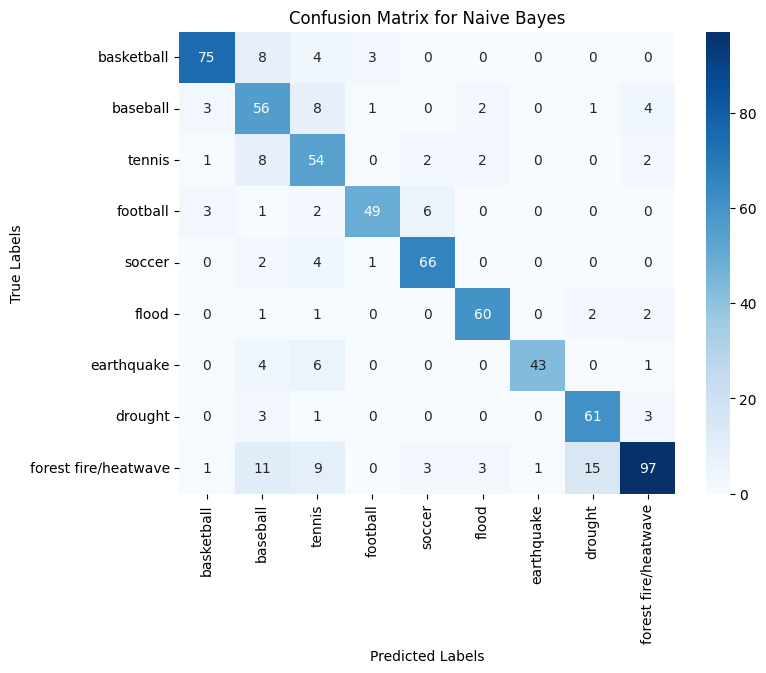

---Scores for Naive Bayes---
Accuracy: 0.8060344827586207
Recall: 0.8183666827768467
Precision: 0.8228340274681891
F1-Score: 0.8149274701791039


In [ ]:
## Classifier
clf = GaussianNB()
predictions = clf.fit(LSI_train, label_train_merged).predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test_merged, predictions, labels=ordered_labels_merged)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels_merged, yticklabels=ordered_labels_merged)
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Scores
print("---Scores for Naive Bayes---")
show_scores(label_test_merged, predictions, 'macro')

### One-vs-One SVM for merged

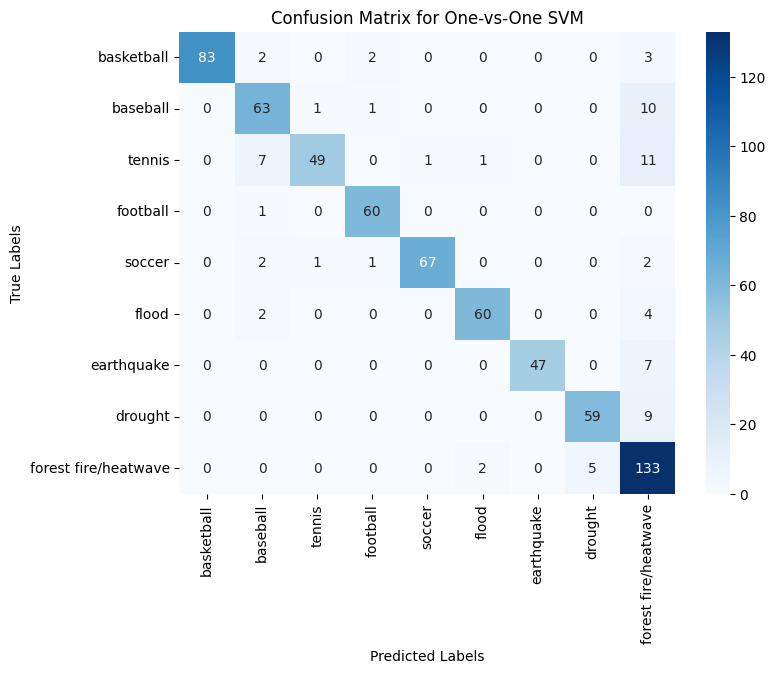

---Scores for One-vs-One SVM---
Accuracy: 0.8922413793103449
Recall: 0.885654473844266
Precision: 0.9243369957457617
F1-Score: 0.9004696708922258


In [ ]:
## Classifier
clf = OneVsOneClassifier(svm.SVC(kernel='linear', C=10, random_state=42)).fit(LSI_train, label_train_merged)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test_merged, predictions, labels=ordered_labels_merged)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels_merged, yticklabels=ordered_labels_merged)
plt.title('Confusion Matrix for One-vs-One SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Scores
print("---Scores for One-vs-One SVM---")
show_scores(label_test_merged, predictions, 'macro')

### One-vs-Rest SVM for merged

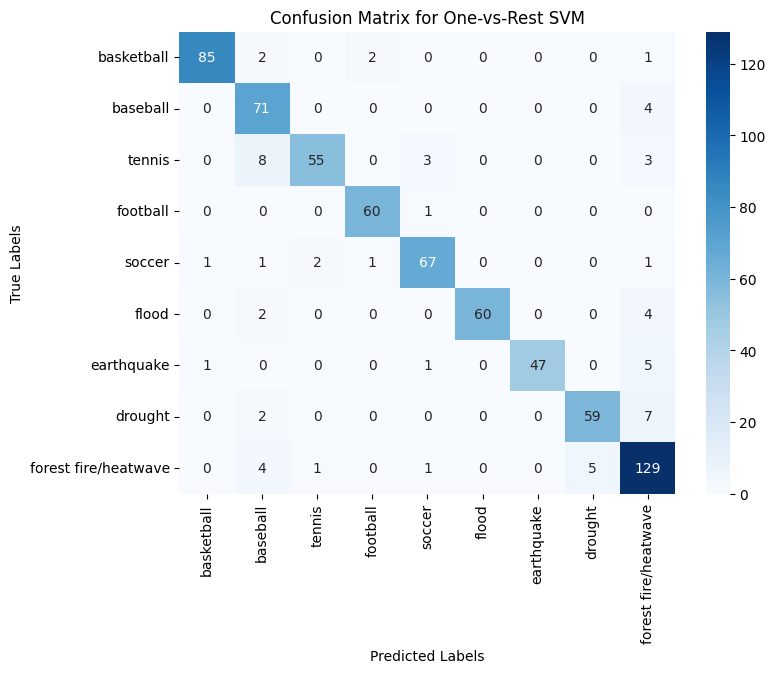

---Scores for One-vs-Rest SVM---
Accuracy: 0.9094827586206896
Recall: 0.906462694072776
Precision: 0.9271003060480112
F1-Score: 0.9141460401097832


In [ ]:
## Classifier
clf = OneVsRestClassifier(svm.SVC(kernel='linear', C=10, random_state=42, class_weight='balanced')).fit(LSI_train, label_train_merged)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test_merged, predictions, labels=ordered_labels_merged)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels_merged, yticklabels=ordered_labels_merged)
plt.title('Confusion Matrix for One-vs-Rest SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Scores
print("---Scores for One-vs-Rest SVM---")
show_scores(label_test_merged, predictions, 'macro')

## Dealing with imbalance

### Downsample merged class to deal with imbalance

In [ ]:
from sklearn.utils import resample

def split_on_label(X, y, label):
    X_with_label = []
    y_with_label = []
    X_without_label = []
    y_without_label = []
    for i, row in enumerate(X):
        if y[i] == label:
            X_with_label.append(row)
            y_with_label.append(y[i])
        else:
            X_without_label.append(row)
            y_without_label.append(y[i])
    return X_with_label, y_with_label, X_without_label, y_without_label

def merge_and_shuffle(X1, y1, X2, y2):
    return resample(X1 + X2, y1 + y2, random_state=42)

## Downsample merged label data by half
X_with_merged, y_with_merged, X_without_merged, y_without_merged = split_on_label(LSI_train, label_train_merged, merged_label_name)
X_with_merged, y_with_merged = resample(X_with_merged, y_with_merged, n_samples=len(y_with_merged)//2, random_state=42)
X_train_resampled, label_train_resampled = merge_and_shuffle(X_with_merged, y_with_merged, X_without_merged, y_without_merged)

### One-vs-One SVM for resampled

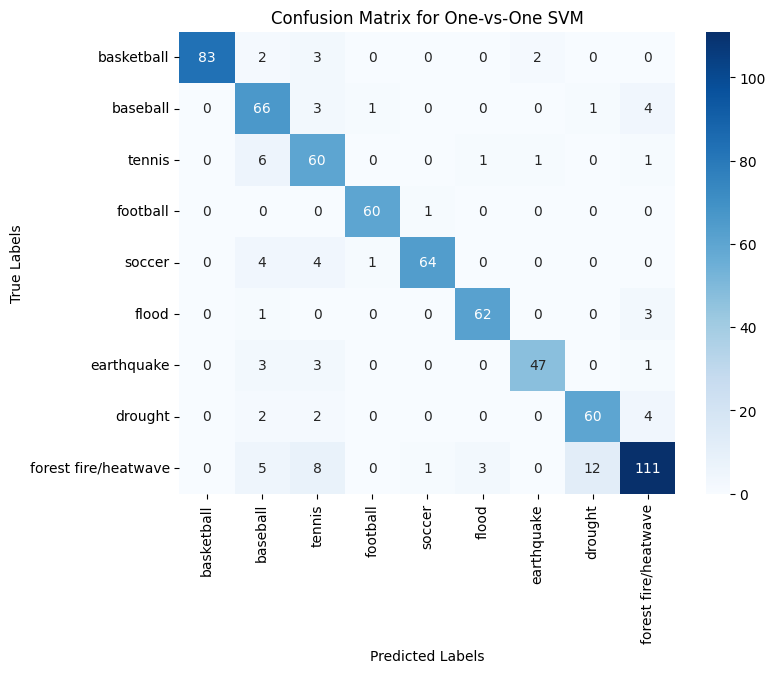

---Scores for One-vs-One SVM---
Accuracy: 0.8807471264367817
Recall: 0.8907867466172914
Precision: 0.8887085047877181
F1-Score: 0.8872861538479829


In [ ]:
## Classifier
clf = OneVsOneClassifier(svm.SVC(kernel='linear', C=10, random_state=42)).fit(X_train_resampled, label_train_resampled)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test_merged, predictions, labels=ordered_labels_merged)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels_merged, yticklabels=ordered_labels_merged)
plt.title('Confusion Matrix for One-vs-One SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Scores
print("---Scores for One-vs-One SVM---")
show_scores(label_test_merged, predictions, 'macro')

### One-vs-Rest SVM for resampled

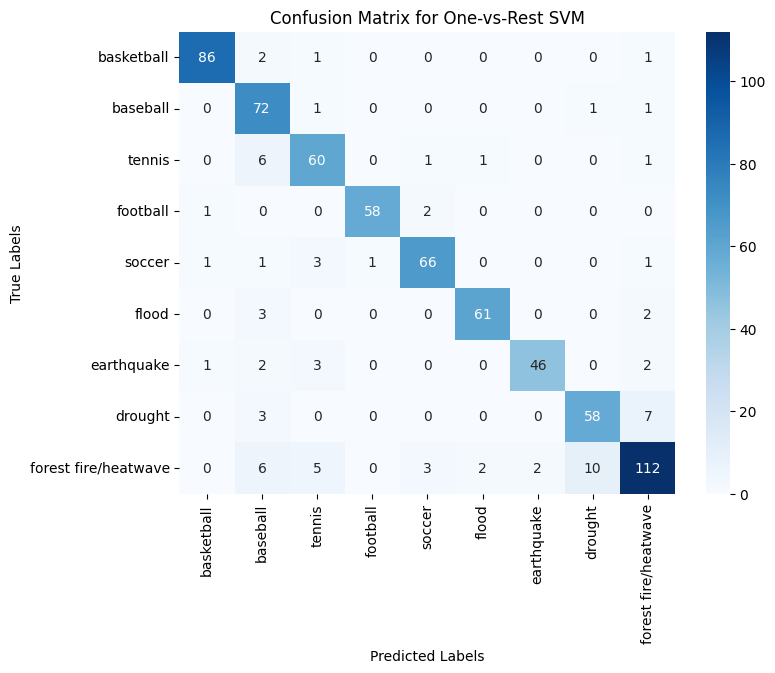

---Scores for One-vs-Rest SVM---
Accuracy: 0.889367816091954
Recall: 0.8965650540759964
Precision: 0.8977500001416474
F1-Score: 0.8951248396855489


In [ ]:
## Classifier
clf = OneVsRestClassifier(svm.SVC(kernel='linear', C=10, random_state=42, class_weight='balanced')).fit(X_train_resampled, label_train_resampled)
predictions = clf.predict(LSI_test)

## Confusion matrix
cm = confusion_matrix(label_test_merged, predictions, labels=ordered_labels_merged)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels_merged, yticklabels=ordered_labels_merged)
plt.title('Confusion Matrix for One-vs-Rest SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Scores
print("---Scores for One-vs-Rest SVM---")
show_scores(label_test_merged, predictions, 'macro')

## GLoVE embeddings

### Setup

In [16]:
embeddings_dict = {}
dimension_of_glove = 300

with open("glove/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

### Difference between words

In [17]:
print('|| GLoVE["woman"] - GLoVE["man"] || = ', np.linalg.norm(embeddings_dict["woman"] - embeddings_dict["man"], 2))
print('|| GLoVE["wife"] - GLoVE["husband"] || = ', np.linalg.norm(embeddings_dict["wife"] - embeddings_dict["husband"], 2))
print('|| GLoVE["wife"] - GLoVE["husband"] || = ', np.linalg.norm(embeddings_dict["wife"] - embeddings_dict["orange"], 2))

|| GLoVE["woman"] - GLoVE["man"] || =  4.7539396
|| GLoVE["wife"] - GLoVE["husband"] || =  3.1520464
|| GLoVE["wife"] - GLoVE["husband"] || =  8.667715


### Feature engineering

In [18]:
def embed_and_aggregate(dataset, dimension_of_glove):
  X = np.zeros((dataset.shape[0], dimension_of_glove))
  skipped_words = set()

  ## Each document is represented as a single vector, which is
  ## the average of all word vectors it contains
  for i, document in enumerate(dataset):
    tokens = document.split(' ')
    l = len(tokens)
    word_vectors = np.zeros((l, dimension_of_glove))
    for j, word in enumerate(tokens):
      if word not in embeddings_dict:
        skipped_words.add(word)
        continue
      word_vectors[j] = embeddings_dict[word]
    X[i] = np.mean(word_vectors, axis=0)

  print("skipped: ", skipped_words)
  return X


X_emb_train = embed_and_aggregate(lemmatized_train, dimension_of_glove)
X_emb_test = embed_and_aggregate(lemmatized_test, dimension_of_glove)
y_train = train["root_label"]
y_test = test["root_label"]

skipped:  {'valissarakos', 'noaasatellites', 'wsrp', 'schwarber', 'pukki', 'garcas', 'dybala', 'dfad', 'jnior', 'leichte', 'boucl', 'thisand', 'semetary', 'stretchbut', 'giftthis', 'exhilarate', 'swatkins', 'shoewear', 'goverm', 'clutchpoints', 'saudiarabia', 'neibergall', 'sitkin', 'uefas', 'kinsleys', 'powerswerve', 'wainee', 'swimswams', 'baublebar', 'caviezelor', 'mewis', 'yujins', 'oliu', 'cassadee', 'otomatic', 'schwartzs', 'greenspans', 'grissomvaughn', 'trialtrackingdetails', 'teyana', 'statter', 'blundon', 'europeand', 'markta', 'whitcraft', 'nwsneworleans', 'furmans', 'onwentsia', 'chpxf', 'inlest', 'keibert', 'adfg', 'putellas', 'polyfluoroalkyl', 'studioantiques', 'tradearabia', 'magelby', 'acrisure', 'adeles', 'bfcs', 'guestbooks', 'arenz', 'barclaysbarclay', 'overtimethe', 'kennedi', 'kassius', 'snmyf', 'alloways', 'rightsso', 'kolek', 'kubernetes', 'stufflebean', 'ahuimanu', 'llorentes', 'howery', 'cruisingcathy', 'scandi', 'latto', 'giarratana', 'kaelepulu', 'snkrs', 'p

### Classification using word embeddings

In [19]:
## SVM
clf = svm.SVC(random_state=42)
c_values = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],
              'kernel': ['linear']}
model = GridSearchCV(clf, c_values, cv=5, scoring='accuracy', n_jobs=-1).fit(X_emb_train, y_train)
predictions = model.best_estimator_.predict(X_emb_test)
print(model.best_params_)
best_C = model.best_params_['C']

{'C': 10, 'kernel': 'linear'}


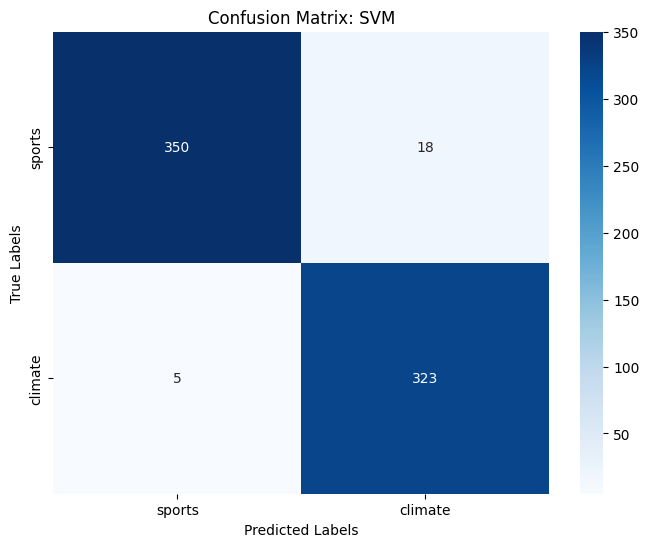

Accuracy: 0.9669540229885057
Precision: 0.9859154929577465
F1 Score: 0.9681881051175657
Recall: 0.9510869565217391


In [20]:
## Confusion matrix
cm = confusion_matrix(y_test, predictions, labels=['sports', 'climate'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sports', 'climate'], yticklabels=['sports', 'climate'])
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Scores
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, pos_label='sports'))
print("F1 Score:", f1_score(y_test, predictions, pos_label='sports'))
print("Recall:", recall_score(y_test, predictions, pos_label='sports'))

#### Plot accuracy by dimension of GLoVE

In [ ]:
dims = [50, 100, 200, 300]
accuracies = []

y_train = train["root_label"]
y_test = test["root_label"]

for glove_dim in dims:
  print(f"Loading GloVE for {glove_dim} dimensions")
  glove_file = f"glove/glove.6B.{glove_dim}d.txt"
  embeddings_dict = {}
  with open(glove_file, 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector

  print("Feature engineering")
  X_emb_train = embed_and_aggregate(lemmatized_train, glove_dim)
  X_emb_test = embed_and_aggregate(lemmatized_test, glove_dim)

  print("Training classifier")
  predictions = svm.SVC(kernel='linear', C=best_C, random_state=42).fit(X_emb_train, y_train).predict(X_emb_test)
  accuracies.append(accuracy_score(y_test, predictions))
  print("Done")

accuracies

Loading GloVE for 50 dimensions
Feature engineering
skipped:  {'charania', 'solene', 'rhinology', 'wilwood', 'christys', 'silvasy', 'sustentvel', 'uccs', 'sbcc', 'pradero', 'airbnbs', 'fansthe', 'trevaughn', 'acrisure', 'antetokounmpo', 'biomaterialmarket', 'assits', 'zwerner', 'swailem', 'bodyboarders', 'fahntolosamarin', 'kazoopys', 'chatgpt', 'tombaroligrave', 'mainean', 'zebronics', 'jpd', 'stephenasmith', 'wfps', 'populistic', 'betrivers', 'calimesa', 'captrs', 'foggins', 'geosyntec', 'neubers', 'vhc', 'serby', 'colourway', 'charlis', 'leslies', 'conclusionsask', 'designboom', 'hanot', 'messian', 'yeck', 'gettr', 'coulibalys', 'infantinos', 'otoole', 'guillott', 'frostpunk', 'unpausing', 'relevents', 'insurancenatcat', 'louks', 'wyers', 'passtarnews', 'mayssas', 'beltr', 'cfields', 'datalayercreditsusedkey', 'chiapanecos', 'ednaldo', 'rohrwacher', 'zegler', 'reportsemiconductors', 'yeroham', 'blangiardi', 'ferr', 'unist', 'jhone', 'thinki', 'kipahulu', 'serratelli', 'dimeglio', 's

[0.9410919540229885,
 0.9568965517241379,
 0.9683908045977011,
 0.9669540229885057]

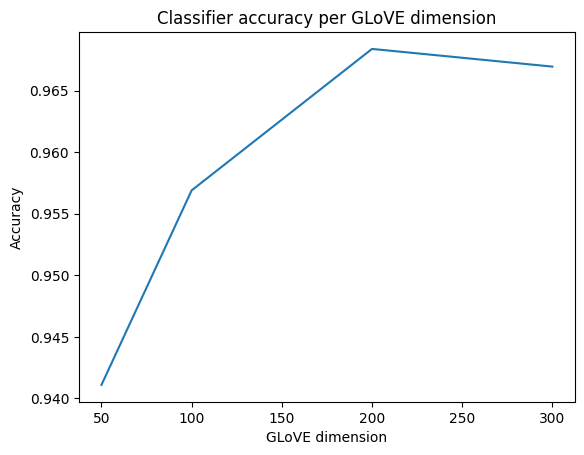

In [ ]:
plt.plot(dims, accuracies)
plt.title("Classifier accuracy per GLoVE dimension")
plt.ylabel("Accuracy")
plt.xlabel("GLoVE dimension")
plt.show()

### UMAP visualization

In [24]:
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
## UMAP embedding of GLoVE
X_emb = np.vstack((X_emb_train, X_emb_test))
y_emb = np.hstack((y_train, y_test))
scaled_glove_vectors = StandardScaler().fit_transform(X_emb)

reducer_glove = umap.UMAP()
embedding = reducer_glove.fit_transform(scaled_glove_vectors)
embedding.shape

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(3476, 2)

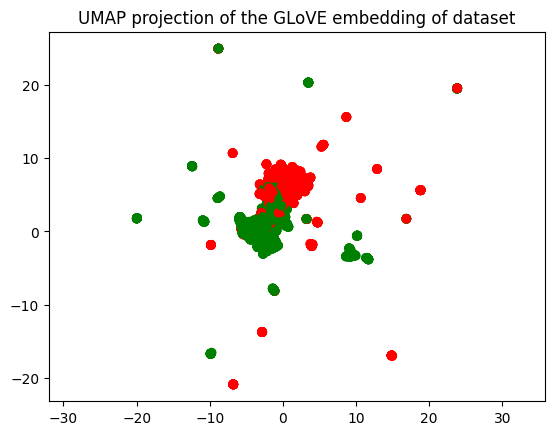

In [42]:
## Plot
color_map = {"sports": "red", "climate": "green"}
colors = [color_map[y_emb[i]] for i in range(X_emb.shape[0])]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the GLoVE embedding of dataset');

In [50]:
## Random generated data
X_rand = np.random.rand(X_emb.shape[0], X_emb.shape[1])
y_rand = np.random.randint(0, 2, y_emb.shape[0])
scaled_rand_vectors = StandardScaler().fit_transform(X_emb)

reducer_rand = umap.UMAP()
embedding = reducer_rand.fit_transform(scaled_rand_vectors)
embedding.shape

array([[-0.52188585, -0.74708142, -0.95193986, ...,  0.9817559 ,
        -0.61009667,  0.46890898],
       [-0.83841223,  1.07585696,  1.0605166 , ...,  0.23870586,
        -0.11567777, -0.45668305],
       [-0.39462473, -0.58332318, -0.48997974, ..., -0.63957579,
         1.24679905,  0.17711343],
       ...,
       [ 1.93839057, -1.43543865, -1.12375195, ..., -1.03455854,
         0.73742474,  0.27078648],
       [ 0.20018268, -0.55215991, -0.18879793, ..., -0.83892332,
        -1.80742007,  1.96056961],
       [-0.24841642, -2.5958016 , -2.13857058, ..., -0.01813373,
         4.56615656,  1.81722538]])